In [1]:
!pip install -q clu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.4.0 which is incompatible.


In [2]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [3]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-14 09:59:46--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-05-14 09:59:46 (18.0 MB/s) - 'input.txt' saved [1115394/1115394]



In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [8]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [11]:
batch_size = 256 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 256
expans = 4
n_heads = 4
channel_size = n_embd // n_heads
n_layers = 4
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(256, 64)
[[ 6  1 61 ... 53 50 42]
 [21  1 42 ... 44 47 43]
 [58 46 43 ... 43 56 43]
 ...
 [ 6  0 13 ... 46 53 59]
 [45 56 39 ...  1 41 53]
 [ 1 51 43 ... 57 46 53]]
targets:
(256, 64)
[[ 1 61 46 ... 50 42  0]
 [ 1 42 47 ... 47 43 56]
 [46 43  1 ... 56 43  1]
 ...
 [ 0 13 52 ... 53 59 45]
 [56 39 41 ... 41 53 51]
 [51 43 52 ... 46 53 61]]


In [12]:
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,)) # TODO, maybe use setup will be more clear
        normed = x * jax.lax.rsqrt(np.mean(np.square(x), axis=-1, keepdims=True) + self.eps)
        output = normed * weight
        return output

In [13]:
xb.shape

(256, 64)

In [14]:
class Expan_proj(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=n_embd)(x)
        return x
    
in_proj = nn.Dense(features=n_embd)
params = in_proj.init(rng_key, xb)
in_proj.apply(params, xb).shape

(256, 256)

In [15]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (256,), 'kernel': (64, 256)}}

# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu -->

In [16]:
class MambaBlock(nn.Module):
    
    def setup(self):
        emb_features = (n_embd // n_heads) * expans
        self.in_proj1 = nn.Dense(features=emb_features)
        self.in_proj2 = nn.Dense(features=emb_features)
        
        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=emb_features,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, emb_features, 1))
        self.B = self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1,emb_features, block_size))
        
        self.out_proj = nn.Dense(n_embd // n_heads)
        
#         self.rms_norm = nn.RMSNorm()
        
    def __call__(self, x):
        
        embeds = x
        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)[1]
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)
        
#         x = self.rms_norm(x)
        
        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.C * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        h = 0
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))
        return h, jnp.stack(y, -1)

In [17]:
# model = MambaBlock()
# params = model.init(jax.random.key(0), xb)
# print(model.tabulate(jax.random.key(0), xb,
#                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, xb)
# xb.shape, xs.shape

In [18]:
class MultiHeadMamba(nn.Module):
    def setup(self):
        self.heads = [MambaBlock() for _ in range(n_heads)]
        self.rms_norm = nn.RMSNorm()
        
    def __call__(self, x):
        out = jnp.concatenate([h(x) for h in self.heads], axis=-1)
        x = self.rms_norm(out)
        return x

In [19]:
class Mamba(nn.Module):
    
    def setup(self):
        self.embeddings = nn.Embed(vocab_size, n_embd)
        
        self.mamba_layers = [MultiHeadMamba() for _ in range(n_layers)]
        
    def __call__(self, x):
        x = self.embeddings(x)
        
        for layer in self.mamba_layers:
            x = layer(x)
            
        out = self.embeddings.attend(x)
        return out
    
    @jax.jit
    def generate(self, idx, max_new_tokens, params):
    # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self.apply(params, idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
            # append sampled index to the running sequence
            idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
    #         print(idx_next)
    #         print(idx)

        return idx

In [20]:
class NanoLM(nn.Module):
    """NanoLM model."""
    vocab_size: int = 65
    num_layers: int = 6
    num_heads: int = 8
    head_size: int = 32
    dropout_rate: float = 0.2
    embed_size: int = 256
    block_size: int = 64

    @nn.compact
    def __call__(self, x, training: bool):
        seq_len = x.shape[1]

        x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
            self.block_size, self.embed_size
        )(jnp.arange(seq_len))
        for _ in range(self.num_layers):
            x_norm = nn.LayerNorm()(x)
            x = x + nn.MultiHeadDotProductAttention(
              num_heads=self.num_heads,
              qkv_features=self.head_size,
              out_features=self.head_size * self.num_heads,
              dropout_rate=self.dropout_rate,
            )(
              x_norm,
              x_norm,
              mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
              deterministic=not training,
            )

            x = x + nn.Sequential([
              nn.Dense(4 * self.embed_size),
              nn.relu,
              nn.Dropout(self.dropout_rate, deterministic=not training),
              nn.Dense(self.embed_size),
            ])(nn.LayerNorm()(x))

        x = nn.LayerNorm()(x)
        return nn.Dense(self.vocab_size)(x)

In [21]:
fin_model = Mamba()
fin_params = fin_model.init(jax.random.key(42), xb)
n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
print(f"Total number of parameters: {n_params:_}")
# print(fin_model.tabulate(jax.random.key(42), xb,
#                    compute_flops=True, compute_vjp_flops=True))
xf = fin_model.apply(fin_params, xb)
xb.shape, xf.shape

Total number of parameters: 5_896_448


((256, 64), (256, 64, 65))

In [22]:
n_embd * expans

1024

In [23]:
# token_gen = generate(jnp.zeros((1,1)).astype(jnp.int32), 100, fin_model, fin_params)
# print(token_gen)
# print(decode(token_gen[0].tolist()))

In [24]:
jax.random.categorical(jax.random.PRNGKey(5332), 1000.0*xf[1][-1][:])

Array(31, dtype=int32)

In [25]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [26]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32))['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [27]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [28]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [29]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [30]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [31]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [32]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results... 
    
      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)
    
    key = (jax.random.split(key)[0])
    
    if (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

  2%|▏         | 100/5000 [08:09<1:10:38,  1.16it/s] 

train epoch: 100, loss: 3.168349266052246, accuracy: 19.8348388671875
test epoch: 100, loss: 2.7999536991119385, accuracy: 27.34375


  4%|▍         | 200/5000 [09:07<1:04:16,  1.24it/s]

train epoch: 200, loss: 2.4382925033569336, accuracy: 35.598201751708984
test epoch: 200, loss: 2.14980149269104, accuracy: 43.54248046875


  6%|▌         | 300/5000 [10:06<1:03:27,  1.23it/s]

train epoch: 300, loss: 1.7893034219741821, accuracy: 51.8170166015625
test epoch: 300, loss: 1.5992058515548706, accuracy: 56.6162109375


  8%|▊         | 400/5000 [11:04<1:02:11,  1.23it/s]

train epoch: 400, loss: 1.3208593130111694, accuracy: 63.9376220703125
test epoch: 400, loss: 1.2996058464050293, accuracy: 64.617919921875


 10%|█         | 500/5000 [12:03<1:00:36,  1.24it/s]

train epoch: 500, loss: 1.0654363632202148, accuracy: 70.98797607421875
test epoch: 500, loss: 1.09140944480896, accuracy: 70.5322265625


 12%|█▏        | 600/5000 [13:01<59:27,  1.23it/s]  

train epoch: 600, loss: 1.0765817165374756, accuracy: 71.2349853515625
test epoch: 600, loss: 1.1912798881530762, accuracy: 68.798828125


 14%|█▍        | 700/5000 [14:00<58:08,  1.23it/s]

train epoch: 700, loss: 1.0811851024627686, accuracy: 71.72130584716797
test epoch: 700, loss: 1.1066827774047852, accuracy: 71.03271484375


 16%|█▌        | 800/5000 [14:58<56:50,  1.23it/s]

train epoch: 800, loss: 0.8402427434921265, accuracy: 77.73828125
test epoch: 800, loss: 0.7452026605606079, accuracy: 80.18798828125


 18%|█▊        | 900/5000 [15:57<55:28,  1.23it/s]

train epoch: 900, loss: 0.7645444869995117, accuracy: 79.943115234375
test epoch: 900, loss: 0.754840612411499, accuracy: 79.9560546875


 20%|██        | 1000/5000 [16:56<54:05,  1.23it/s]

train epoch: 1000, loss: 0.6961243748664856, accuracy: 81.79644012451172
test epoch: 1000, loss: 0.7640081644058228, accuracy: 79.888916015625


 22%|██▏       | 1100/5000 [17:54<52:40,  1.23it/s]

train epoch: 1100, loss: 0.6102345585823059, accuracy: 83.92449951171875
test epoch: 1100, loss: 0.5327390432357788, accuracy: 86.029052734375


 24%|██▍       | 1200/5000 [18:53<51:25,  1.23it/s]

train epoch: 1200, loss: 0.7131426334381104, accuracy: 81.65545654296875
test epoch: 1200, loss: 0.6854284405708313, accuracy: 82.080078125


 26%|██▌       | 1300/5000 [19:51<49:56,  1.23it/s]

train epoch: 1300, loss: 0.5495908856391907, accuracy: 85.67217254638672
test epoch: 1300, loss: 0.5271819829940796, accuracy: 86.358642578125


 28%|██▊       | 1400/5000 [20:50<48:35,  1.23it/s]

train epoch: 1400, loss: 0.6197231411933899, accuracy: 84.16241455078125
test epoch: 1400, loss: 0.683124303817749, accuracy: 82.879638671875


 30%|███       | 1500/5000 [21:49<47:14,  1.23it/s]

train epoch: 1500, loss: 0.6021402478218079, accuracy: 84.25421142578125
test epoch: 1500, loss: 0.635306715965271, accuracy: 83.4716796875


 32%|███▏      | 1600/5000 [22:47<45:57,  1.23it/s]

train epoch: 1600, loss: 0.6042993664741516, accuracy: 84.252685546875
test epoch: 1600, loss: 0.6097800731658936, accuracy: 84.002685546875


 34%|███▍      | 1700/5000 [23:46<44:36,  1.23it/s]

train epoch: 1700, loss: 0.602656900882721, accuracy: 84.32171630859375
test epoch: 1700, loss: 0.6600338816642761, accuracy: 82.92236328125


 36%|███▌      | 1800/5000 [24:44<43:07,  1.24it/s]

train epoch: 1800, loss: 0.6018842458724976, accuracy: 84.28204345703125
test epoch: 1800, loss: 0.6414636373519897, accuracy: 82.757568359375


 38%|███▊      | 1900/5000 [25:43<41:51,  1.23it/s]

train epoch: 1900, loss: 0.6529209613800049, accuracy: 82.96533203125
test epoch: 1900, loss: 0.6176559329032898, accuracy: 83.30078125


 40%|████      | 2000/5000 [26:41<40:26,  1.24it/s]

train epoch: 2000, loss: 0.5544307827949524, accuracy: 85.271240234375
test epoch: 2000, loss: 0.5913350582122803, accuracy: 84.661865234375


 42%|████▏     | 2100/5000 [27:40<39:10,  1.23it/s]

train epoch: 2100, loss: 0.6070602536201477, accuracy: 84.101318359375
test epoch: 2100, loss: 0.6080255508422852, accuracy: 83.70361328125


 44%|████▍     | 2200/5000 [28:38<37:41,  1.24it/s]

train epoch: 2200, loss: 0.5834430456161499, accuracy: 84.35748291015625
test epoch: 2200, loss: 0.5823723077774048, accuracy: 84.649658203125


 46%|████▌     | 2300/5000 [29:36<36:17,  1.24it/s]

train epoch: 2300, loss: 0.7731757164001465, accuracy: 80.25677490234375
test epoch: 2300, loss: 0.7781033515930176, accuracy: 79.296875


 48%|████▊     | 2400/5000 [30:35<35:04,  1.24it/s]

train epoch: 2400, loss: 0.7071372866630554, accuracy: 81.354248046875
test epoch: 2400, loss: 0.6754817962646484, accuracy: 81.70166015625


 50%|█████     | 2500/5000 [31:33<33:38,  1.24it/s]

train epoch: 2500, loss: 0.7400979995727539, accuracy: 80.84783935546875
test epoch: 2500, loss: 0.836234450340271, accuracy: 78.57666015625


 52%|█████▏    | 2600/5000 [32:32<32:18,  1.24it/s]

train epoch: 2600, loss: 0.6822705864906311, accuracy: 82.11187744140625
test epoch: 2600, loss: 0.6374741792678833, accuracy: 83.251953125


 54%|█████▍    | 2700/5000 [33:30<30:55,  1.24it/s]

train epoch: 2700, loss: 0.6831393241882324, accuracy: 82.151123046875
test epoch: 2700, loss: 0.644639253616333, accuracy: 82.87353515625


 56%|█████▌    | 2800/5000 [34:28<29:42,  1.23it/s]

train epoch: 2800, loss: 0.6271603107452393, accuracy: 83.43798828125
test epoch: 2800, loss: 0.5839618444442749, accuracy: 84.222412109375


 58%|█████▊    | 2900/5000 [35:27<28:19,  1.24it/s]

train epoch: 2900, loss: 0.6128658056259155, accuracy: 84.05438232421875
test epoch: 2900, loss: 0.9590317606925964, accuracy: 77.520751953125


 60%|██████    | 3000/5000 [36:25<26:56,  1.24it/s]

train epoch: 3000, loss: 0.818511426448822, accuracy: 78.8372802734375
test epoch: 3000, loss: 0.7560967803001404, accuracy: 79.998779296875


 62%|██████▏   | 3100/5000 [37:23<25:34,  1.24it/s]

train epoch: 3100, loss: 0.7512869238853455, accuracy: 80.50604248046875
test epoch: 3100, loss: 0.8768472671508789, accuracy: 76.837158203125


 64%|██████▍   | 3200/5000 [38:22<24:15,  1.24it/s]

train epoch: 3200, loss: 0.7621373534202576, accuracy: 80.21551513671875
test epoch: 3200, loss: 0.8558695912361145, accuracy: 79.06494140625


 66%|██████▌   | 3300/5000 [39:20<22:54,  1.24it/s]

train epoch: 3300, loss: 0.7357709407806396, accuracy: 80.7916259765625
test epoch: 3300, loss: 0.7036192417144775, accuracy: 81.15234375


 68%|██████▊   | 3400/5000 [40:19<21:31,  1.24it/s]

train epoch: 3400, loss: 0.7289646863937378, accuracy: 80.645751953125
test epoch: 3400, loss: 0.8051937818527222, accuracy: 78.47900390625


 70%|███████   | 3500/5000 [41:17<20:10,  1.24it/s]

train epoch: 3500, loss: 0.703989565372467, accuracy: 81.29161834716797
test epoch: 3500, loss: 0.7047834396362305, accuracy: 81.353759765625


 72%|███████▏  | 3600/5000 [42:15<18:47,  1.24it/s]

train epoch: 3600, loss: 0.6770564913749695, accuracy: 81.9466552734375
test epoch: 3600, loss: 0.6883752346038818, accuracy: 81.463623046875


 74%|███████▍  | 3700/5000 [43:14<17:29,  1.24it/s]

train epoch: 3700, loss: 0.732297420501709, accuracy: 80.76617431640625
test epoch: 3700, loss: 0.7078313827514648, accuracy: 80.987548828125


 76%|███████▌  | 3800/5000 [44:12<16:09,  1.24it/s]

train epoch: 3800, loss: 0.6487010717391968, accuracy: 82.6114501953125
test epoch: 3800, loss: 0.6339958906173706, accuracy: 82.940673828125


 78%|███████▊  | 3900/5000 [45:10<14:46,  1.24it/s]

train epoch: 3900, loss: 0.6601284146308899, accuracy: 82.58673095703125
test epoch: 3900, loss: 0.7492900490760803, accuracy: 80.33447265625


 80%|████████  | 4000/5000 [46:09<13:26,  1.24it/s]

train epoch: 4000, loss: 0.660476803779602, accuracy: 82.3695068359375
test epoch: 4000, loss: 0.6785284876823425, accuracy: 81.744384765625


 82%|████████▏ | 4100/5000 [47:07<12:05,  1.24it/s]

train epoch: 4100, loss: 0.7618792653083801, accuracy: 80.38982391357422
test epoch: 4100, loss: 0.8205088973045349, accuracy: 78.94287109375


 84%|████████▍ | 4200/5000 [48:05<10:45,  1.24it/s]

train epoch: 4200, loss: 0.7663324475288391, accuracy: 79.886474609375
test epoch: 4200, loss: 0.7384448051452637, accuracy: 80.2001953125


 86%|████████▌ | 4300/5000 [49:03<09:24,  1.24it/s]

train epoch: 4300, loss: 0.7040730714797974, accuracy: 81.1220703125
test epoch: 4300, loss: 0.6844497323036194, accuracy: 81.55517578125


 88%|████████▊ | 4400/5000 [50:02<08:04,  1.24it/s]

train epoch: 4400, loss: 0.7583792209625244, accuracy: 80.11083984375
test epoch: 4400, loss: 0.7666301727294922, accuracy: 79.638671875


 90%|█████████ | 4500/5000 [51:00<06:43,  1.24it/s]

train epoch: 4500, loss: 0.7133095264434814, accuracy: 80.8345947265625
test epoch: 4500, loss: 0.7774495482444763, accuracy: 80.0048828125


 92%|█████████▏| 4600/5000 [51:58<05:22,  1.24it/s]

train epoch: 4600, loss: 0.7541666030883789, accuracy: 79.89654541015625
test epoch: 4600, loss: 0.7757731676101685, accuracy: 79.150390625


 94%|█████████▍| 4700/5000 [52:57<04:01,  1.24it/s]

train epoch: 4700, loss: 0.7376834154129028, accuracy: 80.22320556640625
test epoch: 4700, loss: 0.7332619428634644, accuracy: 79.888916015625


 96%|█████████▌| 4800/5000 [53:55<02:41,  1.24it/s]

train epoch: 4800, loss: 0.7217366099357605, accuracy: 80.78338623046875
test epoch: 4800, loss: 0.6998703479766846, accuracy: 81.34765625


 98%|█████████▊| 4900/5000 [54:53<01:20,  1.24it/s]

train epoch: 4900, loss: 0.6930798292160034, accuracy: 81.5010986328125
test epoch: 4900, loss: 0.7137150168418884, accuracy: 80.914306640625


100%|██████████| 5000/5000 [55:51<00:00,  1.49it/s]

train epoch: 5000, loss: 0.7221612930297852, accuracy: 80.650634765625
test epoch: 5000, loss: 0.7156722545623779, accuracy: 80.816650390625


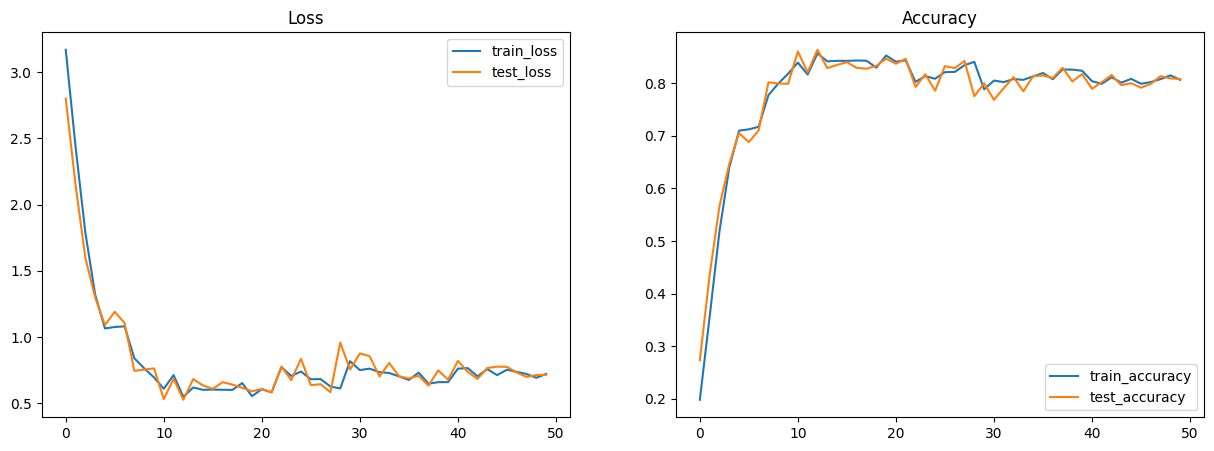

<Figure size 640x480 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [34]:

logits = fin_model.apply(fin_params, xb)
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

4.6824856


In [35]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)
            
#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)

        
#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx

In [36]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context)
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

/opt/conda/lib/python3.10/site-packages/jax/_src/api_util.py:231: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [37]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[24, 19, 47, 31, 51, 31, 51, 10, 8, 58, 61, 53, 50, 52, 1, 52, 53, 18, 1, 57, 46, 53, 60, 50, 60, 43, 56, 43, 1, 41, 53, 50, 42, 1, 46, 39, 40, 58, 57, 1, 56, 43, 56, 39, 57, 2, 57, 1, 57, 43, 58, 1, 43, 44, 58, 59, 59, 58, 45, 1, 53, 52, 1, 56, 39, 52, 1, 53, 8, 56, 39, 52, 45, 50, 0, 13, 39, 1, 57, 53, 53, 46, 58, 50, 0, 30, 52, 32, 58, 41, 58, 39, 24, 59, 10, 46, 43, 56, 50, 47, 39, 57, 43, 50, 50, 56, 39, 57, 1, 40, 53, 51, 57, 1, 58, 53, 1, 58, 46, 46, 1, 61, 46, 39, 50, 1, 39, 59, 1, 57, 43, 43, 57, 1, 21, 43, 1, 53, 44, 1, 58, 46, 47, 52, 45, 1, 47, 41, 8, 1, 31, 56, 30, 49, 30, 58, 21, 12, 31, 21, 33, 31, 31, 10, 24, 58, 10, 0, 19, 53, 19, 47, 24, 21, 21, 10, 0, 14, 58, 43, 56, 52, 39, 58, 43, 56, 1, 40, 53, 40, 57, 1, 50, 63, 1, 46, 39, 53, 57, 1, 47, 52, 0, 40, 43, 1, 58, 53, 1, 51, 53, 40, 59, 58, 1, 42, 43, 45, 56, 53, 51, 39, 57, 43, 1, 58, 53, 1, 39, 56, 56, 43, 1, 47, 53, 49, 56, 39, 50, 50, 1, 58, 53, 50, 0, 24, 58, 6, 6, 39, 42, 1, 53, 1, 46, 53, 52, 57, 6, 47, 53, 52,

In [38]:
print(decode(token_gen))

LGiSmSm:.twoln noF shovlvere cold habts reras!s set eftuutg on ran o.rangl
Aa soohtl
RnTtctaLu:herliasellras boms to thh whal au sees Ie of thing ic. SrRkRtI?SIUSS:Lt:
GoGiLII:
Bternater bobs ly haos in
be to mobut degromase to arre iokrall tol
Lt,,ad o hons,ion, nof pher thuts ra tell at sigpau barry.

BL.A
Yhe ds,:
Io.ty
CrA Camaedall I tisfI Leroanef emd, wron, he thamaattes thioherroshe tharob!c
Bas yasd theal? Ir amd wrog nard:re Lyllenosy to tlaer nat uet shire e is pou meriocs ll
Is nom moh.
ViSoL lenons cosiion whe Is ur birimnalublihe marlatrol, hah,?hoy ghes ter adedoon
Inesa soruthe hon anp fo soibhiinkeat s sas noIg peres tht' nas:t potg id goukses
Whol; shotrus!v
MiRsRy:lnt nols sith wheasre le yu nos thawe to gipamenbing fhan o tikleg dererf to idos.l matta'won.rows, Toul.
Bog,ch he llceng Toal. Port
KmW es bacaltn tiot anmitoIs oy fODAGFHel.iDe:
Caarlate.dapfeluvath tod for anecs ret bemss bist hafe hot sau the dri sors whals yaue  dieucs Irumne moun irnte barfed tis',
S

In [39]:
att_model = NanoLM(
    vocab_size=vocab_size,
    num_layers=4,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=256,
    block_size=64,
)

var_params = att_model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)

n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

Total number of parameters: 2_289_089


In [40]:
jax.random.categorical(jax.random.PRNGKey(100), jnp.array([10.0,-10.0,-10.0,10.0,-11.0,-11.0,-11.0,-100.0,-1000]))

Array(3, dtype=int32)

In [41]:
logitss = state.apply_fn({'params': state.params}, (43*jnp.zeros((1,1))).astype(jnp.int32))[:,-1,:]

In [42]:
token_gen[:,-32:]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
print("gen text: ",print(decode(token_gen[0].tolist())), "end of text")

In [ ]:
jax.random.randint(jax.random.PRNGKey(52), (1,32), minval, maxval

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np

logitss = state.apply_fn({'params': state.params}, xbb[0].reshape(1,32))[:,-1,:]

probs = F.softmax(torch.from_numpy(np.asarray(logitss)), dim=-1) # (B, C)
# sample from the distribution
idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
idx_next

In [ ]:
state.tx.